
## Лабораторная работа №1: Фильтр Блума
 
### Задачи:
1. Реализовать фильтр Блума с собственными хеш-функциями
2. Определить процент ложноположительных срабатываний
3. Исследовать зависимость ложноположительных срабатываний от параметров m и k
4. Реализовать операции объединения и пересечения фильтров


### Задание 1: Реализация фильтра Блума

In [46]:
import hashlib
import matplotlib.pyplot as plt

In [47]:
class BloomFilter:
    def __init__(self, m, k):
        self.m = m  # Размер битового массива
        self.k = k  # Количество хеш-функций
        self.bits = [False] * m  # Битовый массив

    def add(self, element):
        for i in range(self.k):
            index = self._hash(element, i) % self.m
            self.bits[index] = True

    def check(self, element):
        for i in range(self.k):
            index = self._hash(element, i) % self.m
            if not self.bits[index]:
                return False
        return True

    def _hash(self, element, i):
        hasher = hashlib.sha256()
        hasher.update(f"{i}".encode() + str(element).encode())
        return int(hasher.hexdigest(), 16)

    def union(self, other):
        if self.m != other.m or self.k != other.k:
            raise ValueError("Фильтры должны иметь одинаковые m и k")
        new_bf = BloomFilter(self.m, self.k)
        for i in range(self.m):
            new_bf.bits[i] = self.bits[i] or other.bits[i]
        return new_bf

    def intersection(self, other):
        if self.m != other.m or self.k != other.k:
            raise ValueError("Фильтры должны иметь одинаковые m и k")
        new_bf = BloomFilter(self.m, self.k)
        for i in range(self.m):
            new_bf.bits[i] = self.bits[i] and other.bits[i]
        return new_bf

In [48]:
def test_bloom_filter(m, k, n_elements=100, n_tests=1000):
    bf = BloomFilter(m, k)
    added = [f"el{i}" for i in range(n_elements)]
    for el in added:
        bf.add(el)
    
    false_positives = 0
    for i in range(n_tests):
        test_el = f"test_{i}"
        if bf.check(test_el):
            false_positives += 1
    
    return (false_positives / n_tests) * 100

m=100, k=1: 62.40%
m=100, k=2: 75.40%
m=100, k=3: 89.60%
m=100, k=5: 100.00%
m=200, k=1: 35.80%
m=200, k=2: 34.50%
m=200, k=3: 49.40%
m=200, k=5: 78.30%
m=500, k=1: 20.00%
m=500, k=2: 10.50%
m=500, k=3: 9.70%
m=500, k=5: 12.10%
m=1000, k=1: 11.80%
m=1000, k=2: 3.50%
m=1000, k=3: 2.20%
m=1000, k=5: 1.30%


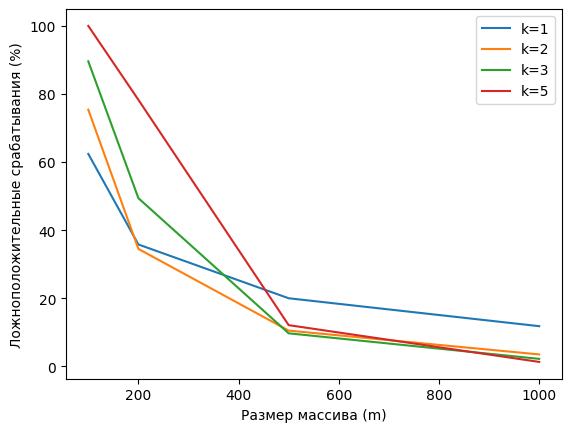

In [49]:
# Параметры
ms = [100, 200, 500, 1000]
ks = [1, 2, 3, 5]
results = {}

for m in ms:
    for k in ks:
        rate = test_bloom_filter(m, k)
        results[(m, k)] = rate
        print(f"m={m}, k={k}: {rate:.2f}%")

# Построение графиков
for k in ks:
    x = [m for m in ms]
    y = [results[(m, k)] for m in ms]
    plt.plot(x, y, label=f'k={k}')

plt.xlabel('Размер массива (m)')
plt.ylabel('Ложноположительные срабатывания (%)')
plt.legend()
plt.show()

In [50]:
class CountingBloomFilter:
    def __init__(self, m, k):
        self.counts = [0] * m
        self.k = k

    def add(self, element):
        for i in range(self.k):
            index = self._hash(element, i) % self.m
            self.counts[index] += 1

    def remove(self, element):
        for i in range(self.k):
            index = self._hash(element, i) % self.m
            if self.counts[index] > 0:
                self.counts[index] -= 1